# L layered Deep Neural Network

# Packages

In [28]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

# Model

![img](https://github.com/Coding-Lane/Deep-Neural-Network-from-scratch/blob/main/images/deep_network.png?raw=1)

# Dataset

In [29]:
import requests
import io

def load_data_from_github(url):
    """Downloads a file from a given GitHub raw URL and loads it into a NumPy array."""
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    return np.loadtxt(io.StringIO(response.text), delimiter=',')

# Base URL of the dataset directory in the GitHub repository
base_url = 'https://raw.githubusercontent.com/ntesan97/dnn/main/dataset/'

# Load training data
X_train = load_data_from_github(base_url + 'cat_train_x.csv') / 255.0
Y_train = load_data_from_github(base_url + 'cat_train_y.csv').reshape(1, X_train.shape[1])

# Load testing data
X_test = load_data_from_github(base_url + 'cat_test_x.csv') / 255.0
Y_test = load_data_from_github(base_url + 'cat_test_y.csv').reshape(1, X_test.shape[1])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


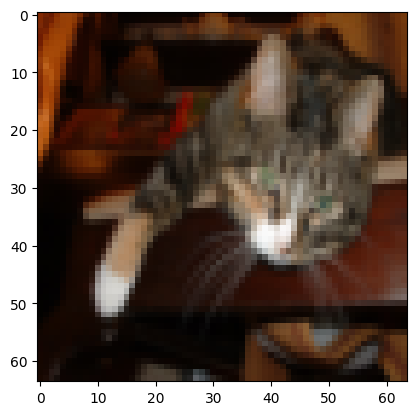

In [30]:
index = random.randrange(0, X_train.shape[1])
plt.imshow(X_train[:, index].reshape(64,64, 3))
plt.show()

# Activation Functions

In [31]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

# Initialize Parameters

- We need to initialize the **W** parameters randomly, and **B** with zeros
- And as our Deep Neural network has **L layers**, we will repeat it for **L-1 times**, from $W_1 to W_L$

<img src="https://github.com/Coding-Lane/Deep-Neural-Network-from-scratch/blob/main/images/params.png?raw=1" width="350"/>

In [32]:
def initialize_parameters(layer_dims):

    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [33]:
layer_dims = [X_train.shape[0], 100, 200, Y_train.shape[0]]
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 12288)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (1, 200)
Shape of B3: (1, 1) 



#### Expected :

Shape of W1: (100, 12288)

Shape of B1: (100, 1)

Shape of W2: (200, 100)

Shape of B2: (200, 1)

Shape of W3: (1, 200)

Shape of B3: (1, 1)

# Forward Propagation

- sigmoid activation function will be used only at the last layer (output layer), while we will use relu/tanh for other layers

<img src="https://github.com/Coding-Lane/Deep-Neural-Network-from-scratch/blob/main/images/forward_prop.png?raw=1" width="300"/>


For f(x), you can use either tanh or ReLU activation function. But also use the derivative of the same for Backpropagation as well

In [34]:
def forward_propagation(X, parameters, activation):

    forward_cache = {}
    L = len(parameters) // 2

    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]

        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])


    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]

    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])

    return forward_cache['A' + str(L)], forward_cache

In [35]:
aL, forw_cache = forward_propagation(X_train, params, 'relu')

for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (12288, 209)
Shape of A1 : (100, 209)
Shape of A2 : (200, 209)
Shape of A3 : (1, 209)


#### Expected :

Shape of A0 : (12288, 209)

Shape of A1 : (100, 209)

Shape of A2 : (200, 209)

Shape of A3 : (1, 209)

# Cost Function

#### For binary classification:
$ Cost = - \frac{1}{m} \sum_{i=1}^{m} [ y*log(a_L) + (1-y)*log(1 - a_L) ] $

#### For multi-class classification:

$ Cost = - \frac{1}{m} \sum_{i=1}^{m} \sum_{i=k}^{n}[ y_k*log(a_k) ]$

In [36]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

# Backward Propagation

- For last layer, **$dZ_L$** will be $A_L - Y$
- Except for last layer, we use a loop to implement backprop for other layers

<img src="https://github.com/Coding-Lane/Deep-Neural-Network-from-scratch/blob/main/images/backward_prop.png?raw=1" width="300"/>

In [37]:
def backward_propagation(AL, Y, parameters, forward_cache, activation):

    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]

    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)

    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])

        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [38]:
grads = backward_propagation(forw_cache["A" + str(3)], Y_train, params, forw_cache, 'relu')

for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 209)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)
Shape of dW1 : (100, 12288)
Shape of dB1 : (100, 1) 



#### Expected Output

Shape of dZ3 : (1, 209)

Shape of dW3 : (1, 200)

Shape of dB3 : (1, 1)

Shape of dZ2 : (200, 209)

Shape of dW2 : (200, 100)

Shape of dB2 : (200, 1)

Shape of dZ1 : (100, 209)

Shape of dW1 : (100, 12288)

Shape of dB1 : (100, 1)

# Update Parameters
<img src="https://github.com/Coding-Lane/Deep-Neural-Network-from-scratch/blob/main/images/update_params.png?raw=1" width="300"/>

In [39]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

# Predictions

In [40]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)

    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)

    return np.round(np.sum((y_pred == y)/m), 2)

# Complete Model

Implement the entire Deep Neural Network here

### Instructions :

We need to initialize parameters once, and after that, we will run the following in a loop:
- forward_prop(x, parameters)
- cost_function(aL, y)
- backward_prop(x, y, parameters, forward_cache)
- parameters = update_parameters(parameters, gradients, learning_rate)

### Return :
- parameters, which will be our trained parameters

In [46]:
def model(X, Y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):#lr was 0.009

    np.random.seed(1)
    costs = []

    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters, activation)

        cost = compute_cost(AL, Y)

        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)

        if i % (num_iterations/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))

        if i % 10 == 0:
            print("==", end = '')


    return parameters

In [47]:
layers_dims = [X_train.shape[0], 20, 7, 5, Y_train.shape[0]] #  4-layer model
lr = 0.0075
iters = 2500

parameters = model(X_train, Y_train, layers_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)


iter:0 	 cost: 0.77 	 train_acc:0.51 	 test_acc:0.42
iter:250 	 cost: 0.63 	 train_acc:0.74 	 test_acc:0.64
iter:500 	 cost: 0.54 	 train_acc:0.78 	 test_acc:0.7
iter:750 	 cost: 0.44 	 train_acc:0.92 	 test_acc:0.78
iter:1000 	 cost: 0.32 	 train_acc:0.96 	 test_acc:0.8
iter:1250 	 cost: 0.23 	 train_acc:0.98 	 test_acc:0.76
iter:1500 	 cost: 0.16 	 train_acc:0.98 	 test_acc:0.82
iter:1750 	 cost: 0.13 	 train_acc:0.98 	 test_acc:0.8
iter:2000 	 cost: 0.11 	 train_acc:0.98 	 test_acc:0.8
iter:2250 	 cost: 0.1 	 train_acc:0.98 	 test_acc:0.8

# Task
Explain what the provided Jupyter notebook does, add educational comments to all code cells, and summarize the key components of the implemented neural network.

## Provide a general overview of the notebook's purpose.

### Subtask:
Provide a general overview of the notebook's purpose.


**Reasoning**:
Based on the markdown and code cells, the notebook implements a deep neural network for image classification. I will now provide a concise description of the notebook's purpose.



In [48]:
# The notebook implements a layered deep neural network from scratch using NumPy.
# It covers the fundamental building blocks of a neural network, including:
# - Data loading and preprocessing (specifically for a cat vs non-cat image dataset).
# - Initialization of parameters (weights and biases).
# - Implementation of activation functions (sigmoid, softmax, ReLU, tanh) and their derivatives.
# - Forward propagation to compute the output of the network.
# - Computation of the cost function (binary and multi-class cross-entropy).
# - Backward propagation to calculate gradients.
# - Updating parameters using gradient descent.
# - Making predictions and evaluating accuracy.
# The notebook then demonstrates training the implemented model on the loaded dataset and shows the progress of the training process by printing the cost and accuracy at intervals.

## Add educational comments to each code cell explaining its functionality.

### Subtask:
Add educational comments to each code cell explaining its functionality.


**Reasoning**:
Add educational comments to the code cell that imports necessary libraries.



In [49]:
# Import necessary libraries for the deep learning model.
import time # Used for timing operations, though not explicitly used in the provided code.
import random # Used for generating random numbers, specifically for selecting a random image to display.
import numpy as np # Fundamental library for numerical operations, essential for matrix manipulations in neural networks.
import matplotlib.pyplot as plt # Library for plotting graphs, used here to display an image.
# from tensorflow.keras.datasets import mnist # This import is commented out and not used in the current notebook.
# from keras.utils import to_categorical # This import is commented out and not used in the current notebook.

**Reasoning**:
Add educational comments to the code cell that loads the dataset from GitHub.



In [50]:
# Import requests for downloading data from a URL and io for working with in-memory text files.
import requests
import io

def load_data_from_github(url):
    """Downloads a file from a given GitHub raw URL and loads it into a NumPy array."""
    # Send a GET request to the specified URL to download the data.
    response = requests.get(url)
    # Raise an HTTPError for bad responses (4xx or 5xx).
    response.raise_for_status()
    # Read the content of the response into a string and then load it into a NumPy array,
    # assuming the data is comma-separated values.
    return np.loadtxt(io.StringIO(response.text), delimiter=',')

# Base URL of the dataset directory in the GitHub repository where the data files are stored.
base_url = 'https://raw.githubusercontent.com/ntesan97/dnn/main/dataset/'

# Load training data for features (X_train) and labels (Y_train).
# X_train is normalized by dividing by 255.0 to scale pixel values between 0 and 1.
X_train = load_data_from_github(base_url + 'cat_train_x.csv') / 255.0
# Y_train is loaded and reshaped to have a shape of (1, number of samples) to match the expected label format.
Y_train = load_data_from_github(base_url + 'cat_train_y.csv').reshape(1, X_train.shape[1])

# Load testing data for features (X_test) and labels (Y_test) following the same process as training data.
X_test = load_data_from_github(base_url + 'cat_test_x.csv') / 255.0
Y_test = load_data_from_github(base_url + 'cat_test_y.csv').reshape(1, X_test.shape[1])

# Print the shapes of the loaded datasets to verify they are loaded correctly.
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


**Reasoning**:
Add educational comments to the code cell that displays a random training image.



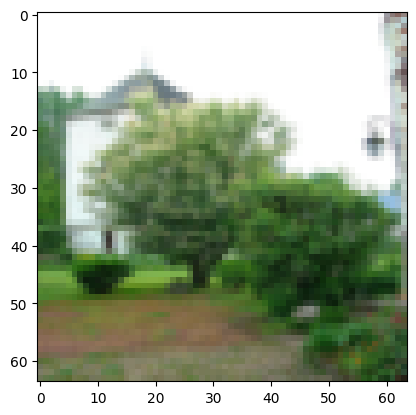

In [51]:
# Select a random index from the range of the number of training examples.
index = random.randrange(0, X_train.shape[1])
# Reshape the selected image data from a flattened vector into a 64x64 pixel, 3-channel (RGB) image
# and display it using matplotlib's imshow function.
plt.imshow(X_train[:, index].reshape(64,64, 3))
# Show the plotted image.
plt.show()

**Reasoning**:
Add educational comments to the code cell defining activation functions and their derivatives.



In [52]:
# Define the sigmoid activation function, which squashes values between 0 and 1.
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

# Define the softmax activation function, used for multi-class classification
# to convert raw scores into probabilities that sum to 1.
def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

# Define the ReLU (Rectified Linear Unit) activation function, which returns the input
# if it's positive, and 0 otherwise.
def relu(Z):
    A = np.maximum(0,Z)
    return A

# Define the tanh (Hyperbolic Tangent) activation function, which squashes values
# between -1 and 1.
def tanh(x):
    return np.tanh(x)

# Define the derivative of the ReLU function, used in backpropagation.
# The derivative is 1 for positive inputs and 0 for non-positive inputs.
def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

# Define the derivative of the tanh function, used in backpropagation.
# The derivative is 1 - tanh(x)^2.
def derivative_tanh(x):
    return (1 - np.power(x, 2))

**Reasoning**:
Add educational comments to the code cell that initializes the parameters of the neural network.



In [53]:
# Define a function to initialize the weights (W) and biases (b) for each layer of the neural network.
def initialize_parameters(layer_dims):

    # Initialize an empty dictionary to store the parameters.
    parameters = {}
    # Get the number of layers in the network (L is the number of weight/bias pairs).
    L = len(layer_dims)

    # Loop through each layer starting from the second layer (l=1) up to the last layer (L-1).
    for l in range(1, L):
        # Initialize weights for the current layer 'l'.
        # Weights are initialized randomly from a standard normal distribution.
        # The scale is divided by the square root of the number of neurons in the previous layer (layer_dims[l-1]).
        # This is a common technique (He initialization for ReLU) to help prevent vanishing/exploding gradients.
        # The shape of W[l] is (number of neurons in current layer, number of neurons in previous layer).
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        # Initialize biases for the current layer 'l' with zeros.
        # The shape of b[l] is (number of neurons in current layer, 1).
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    # Return the dictionary containing the initialized parameters.
    return parameters

**Reasoning**:
Add educational comments to the code cell that tests the parameter initialization function.



In [54]:
# Define the dimensions of each layer in the neural network.
# The first element is the input layer size (number of features),
# the intermediate elements are the number of neurons in the hidden layers,
# and the last element is the output layer size.
layer_dims = [X_train.shape[0], 100, 200, Y_train.shape[0]]
# Initialize the parameters of the neural network using the defined layer dimensions.
params = initialize_parameters(layer_dims)

# Loop through each layer (starting from the second layer, index 1) to print the shapes
# of the initialized weight and bias matrices to verify they are correct.
for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 12288)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (1, 200)
Shape of B3: (1, 1) 



**Reasoning**:
Add educational comments to the code cell implementing the forward propagation.



In [55]:
# Define the forward propagation function to compute the output of the neural network.
# X: Input data.
# parameters: Dictionary containing the weights and biases for each layer.
# activation: The activation function to use for the hidden layers ('relu' or 'tanh').
def forward_propagation(X, parameters, activation):

    # Initialize a dictionary to store the activation values (A) and pre-activation values (Z)
    # for each layer during the forward pass. These are needed for backpropagation.
    forward_cache = {}
    # Calculate the number of layers with learnable parameters (L).
    L = len(parameters) // 2

    # Store the input data X as the activation of the input layer (A0).
    forward_cache['A0'] = X

    # Loop through the hidden layers (from layer 1 to L-1).
    for l in range(1, L):
        # Retrieve the weights (W) and biases (b) for the current layer.
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        # Calculate the pre-activation value (Z) for the current layer: Z[l] = W[l] * A[l-1] + b[l].
        forward_cache['Z' + str(l)] = np.dot(W, forward_cache['A' + str(l-1)]) + b

        # Apply the specified activation function ('relu' or 'tanh') to the pre-activation value
        # to get the activation value (A) for the current layer.
        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])

    # Handle the output layer (layer L).
    # Calculate the pre-activation value (Z) for the output layer.
    forward_cache['Z' + str(L)] = np.dot(parameters['W' + str(L)], forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]

    # Apply the appropriate activation function for the output layer.
    # If the output layer has only one neuron (binary classification), use sigmoid.
    # If the output layer has more than one neuron (multi-class classification), use softmax.
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])

    # Return the final output activation (AL) and the cache containing all intermediate values.
    return forward_cache['A' + str(L)], forward_cache

**Reasoning**:
Add educational comments to the code cell that tests the forward propagation function.



In [56]:
# Perform forward propagation on the training data using the initialized parameters and ReLU activation for hidden layers.
aL, forw_cache = forward_propagation(X_train, params, 'relu')

# Loop through the layers (including the input layer A0) and print the shapes
# of the activation values (A) stored in the forward_cache to verify the dimensions
# after each layer's computation.
for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (12288, 209)
Shape of A1 : (100, 209)
Shape of A2 : (200, 209)
Shape of A3 : (1, 209)


## Add educational comments to each code cell explaining its functionality.

### Subtask:
Add educational comments to each code cell explaining its functionality.


**Reasoning**:
Add detailed educational comments to the code cell that computes the cost function.



In [57]:
# Define the cost function to evaluate the performance of the neural network.
# AL: The predicted output of the neural network (activation of the last layer).
# Y: The true labels.
def compute_cost(AL, Y):
    # Get the number of training examples (m).
    m = Y.shape[1]

    # Compute the cost based on the type of classification task.
    # If the output layer has only one neuron (Y.shape[0] == 1), it's binary classification.
    # The binary cross-entropy loss is calculated.
    if Y.shape[0] == 1:
        # Formula: -(1/m) * sum(y*log(AL) + (1-y)*log(1-AL))
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    # If the output layer has more than one neuron, it's multi-class classification.
    # The categorical cross-entropy loss is calculated.
    else:
        # Formula: -(1/m) * sum(Y * log(AL))
        # Note: Y is expected to be one-hot encoded for this formula.
        cost = -(1./m) * np.sum(Y * np.log(AL))

    # Ensure the cost is a scalar value (e.g., convert [[17]] to 17).
    cost = np.squeeze(cost)

    # Return the computed cost.
    return cost

**Reasoning**:
Add detailed educational comments to the code cell that implements backward propagation.



In [58]:
# Define the backward propagation function to compute the gradients of the cost
# with respect to the weights and biases.
# AL: The predicted output (activation of the last layer).
# Y: The true labels.
# parameters: Dictionary containing the weights and biases.
# forward_cache: Dictionary containing intermediate values from the forward pass (A and Z values).
# activation: The activation function used in hidden layers ('relu' or 'tanh').
def backward_propagation(AL, Y, parameters, forward_cache, activation):

    # Initialize a dictionary to store the gradients.
    grads = {}
    # Get the number of layers with learnable parameters (L).
    L = len(parameters)//2
    # Get the number of training examples (m).
    m = AL.shape[1]

    # --- Backward pass for the output layer (Layer L) ---
    # Calculate the gradient of the cost with respect to the pre-activation value of the output layer (dZ[L]).
    # For binary cross-entropy or categorical cross-entropy with sigmoid/softmax output, dZ[L] = AL - Y.
    grads["dZ" + str(L)] = AL - Y
    # Calculate the gradient of the cost with respect to the weights of the output layer (dW[L]).
    # dW[L] = (1/m) * dZ[L] * A[L-1].T
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    # Calculate the gradient of the cost with respect to the biases of the output layer (db[L]).
    # db[L] = (1/m) * sum(dZ[L]) over all examples.
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)

    # --- Backward pass for the hidden layers (from L-1 down to 1) ---
    # Loop through the hidden layers in reverse order.
    for l in reversed(range(1, L)):
        # Calculate the gradient of the cost with respect to the pre-activation value of the current layer (dZ[l]).
        # This involves backpropagating the gradient from the next layer (dZ[l+1])
        # and multiplying by the derivative of the activation function of the current layer.
        # dZ[l] = (W[l+1].T * dZ[l+1]) * derivative(A[l]).
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else: # activation == 'relu'
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])

        # Calculate the gradient of the cost with respect to the weights of the current layer (dW[l]).
        # dW[l] = (1/m) * dZ[l] * A[l-1].T
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        # Calculate the gradient of the cost with respect to the biases of the current layer (db[l]).
        # db[l] = (1/m) * sum(dZ[l]) over all examples.
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    # Return the dictionary containing the computed gradients.
    return grads

**Reasoning**:
Add detailed educational comments to the code cell that tests the backward propagation function.



In [59]:
# Test the backward propagation function.
# Compute the gradients using the output activation (A3), true labels (Y_train),
# initialized parameters (params), forward cache (forw_cache), and 'relu' activation.
grads = backward_propagation(forw_cache["A" + str(3)], Y_train, params, forw_cache, 'relu')

# Loop through the layers in reverse order (from the last layer down to 1)
# and print the shapes of the computed gradients (dZ, dW, and db) to verify their dimensions.
for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 209)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)
Shape of dW1 : (100, 12288)
Shape of dB1 : (100, 1) 



**Reasoning**:
Add detailed educational comments to the code cell that updates the parameters using gradient descent.



In [60]:
# Define the function to update the neural network's parameters (weights and biases)
# using the gradients computed during backward propagation and a specified learning rate.
# parameters: Dictionary containing the current weights and biases.
# grads: Dictionary containing the computed gradients (dW and db) for each layer.
# learning_rate: The learning rate, a hyperparameter that controls the step size
#                during parameter updates.
def update_parameters(parameters, grads, learning_rate):

    # Get the number of layers with learnable parameters (L).
    L = len(parameters) // 2

    # Loop through each layer (from 0 to L-1).
    for l in range(L):
        # Update the weights for the current layer 'l+1'.
        # New W = Old W - learning_rate * dW.
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        # Update the biases for the current layer 'l+1'.
        # New b = Old b - learning_rate * db.
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    # Return the dictionary containing the updated parameters.
    return parameters

**Reasoning**:
Add detailed educational comments to the code cell that makes predictions.



In [61]:
# Define the function to make predictions using the trained neural network.
# X: Input data for making predictions.
# y: True labels (used for calculating accuracy).
# parameters: Dictionary containing the trained weights and biases.
# activation: The activation function used in hidden layers ('relu' or 'tanh').
def predict(X, y, parameters, activation):

    # Get the number of examples in the input data (m).
    m = X.shape[1]
    # Perform forward propagation on the input data to get the predicted output (y_pred)
    # and the forward cache (though the cache is not used in this function).
    y_pred, caches = forward_propagation(X, parameters, activation)

    # Convert the predicted probabilities into binary predictions (0 or 1) for binary classification.
    # If the true labels y have only one row, it's binary classification.
    # Predictions are rounded to 0 or 1 based on a threshold of 0.5.
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    # For multi-class classification, convert predicted probabilities (output of softmax)
    # and true labels (if not already) into class indices by finding the index of the maximum value.
    else:
        # Assuming y is not one-hot encoded and contains class indices.
        # If y is one-hot encoded, this line might need adjustment.
        y = np.argmax(y, 0)
        # Get the predicted class index for each example.
        y_pred = np.argmax(y_pred, 0)

    # Calculate the accuracy by comparing predicted labels (y_pred) with true labels (y).
    # Sum the number of correct predictions and divide by the total number of examples (m).
    # Round the accuracy to 2 decimal places.
    return np.round(np.sum((y_pred == y)/m), 2)

**Reasoning**:
Add detailed educational comments to the code cell that implements the complete deep neural network model training process.



In [62]:
# Define the main model function that orchestrates the entire deep neural network training process.
# X: Training data features.
# Y: Training data labels.
# layers_dims: A list specifying the number of neurons in each layer (input, hidden, output).
# learning_rate: The learning rate for parameter updates (default is 0.03).
# activation: The activation function to use for hidden layers ('relu' or 'tanh', default is 'relu').
# num_iterations: The number of training iterations (epochs) to run (default is 3000).
def model(X, Y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):#lr was 0.009

    # Set a random seed for reproducibility of results.
    np.random.seed(1)
    # Initialize an empty list to store the cost at different iterations (for plotting later, though not plotted here).
    costs = []

    # Initialize the parameters (weights and biases) of the neural network based on the layer dimensions.
    parameters = initialize_parameters(layers_dims)

    # Start the training loop for the specified number of iterations.
    for i in range(0, num_iterations):

        # --- Forward Propagation ---
        # Perform forward propagation to compute the output of the network (AL)
        # and store intermediate values in the forward_cache.
        AL, forward_cache = forward_propagation(X, parameters, activation)

        # --- Compute Cost ---
        # Calculate the cost (loss) based on the predicted output (AL) and true labels (Y).
        cost = compute_cost(AL, Y)

        # --- Backward Propagation ---
        # Perform backward propagation to compute the gradients of the cost
        # with respect to the parameters.
        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        # --- Update Parameters ---
        # Update the parameters (weights and biases) using the computed gradients
        # and the specified learning rate.
        parameters = update_parameters(parameters, grads, learning_rate)

        # --- Print Progress ---
        # Print the current iteration number, cost, and training/testing accuracy at regular intervals.
        # This helps monitor the training progress. The interval is set to 1/10th of the total iterations.
        if i % (num_iterations/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))

        # Print "==" to show progress visually every 10 iterations.
        if i % 10 == 0:
            print("==", end = '')


    # Return the trained parameters after completing all iterations.
    return parameters

**Reasoning**:
Add detailed educational comments to the code cell that trains the model and prints the final parameters.



In [63]:
# Define the dimensions for a 4-layer neural network (input -> hidden1 -> hidden2 -> hidden3 -> output).
# X_train.shape[0]: Input layer size (number of features).
# 20, 7, 5: Number of neurons in the three hidden layers.
# Y_train.shape[0]: Output layer size (number of output neurons).
layers_dims = [X_train.shape[0], 20, 7, 5, Y_train.shape[0]] #  4-layer model
# Set the learning rate for the gradient descent algorithm.
lr = 0.0075
# Set the total number of training iterations (epochs).
iters = 2500

# Train the model using the defined layers_dims, learning rate, and number of iterations.
# The model function executes the forward propagation, cost computation, backward propagation,
# and parameter update steps for the specified number of iterations.
# The trained parameters are returned and stored in the 'parameters' variable.
parameters = model(X_train, Y_train, layers_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)

# After training, the 'parameters' dictionary contains the optimized weights and biases
# that the model learned from the training data. These parameters can then be used
# to make predictions on new, unseen data.
# Although not explicitly printed here, the 'parameters' variable holds the final trained model.


iter:0 	 cost: 0.77 	 train_acc:0.51 	 test_acc:0.42
iter:250 	 cost: 0.63 	 train_acc:0.74 	 test_acc:0.64
iter:500 	 cost: 0.54 	 train_acc:0.78 	 test_acc:0.7
iter:750 	 cost: 0.44 	 train_acc:0.92 	 test_acc:0.78
iter:1000 	 cost: 0.32 	 train_acc:0.96 	 test_acc:0.8
iter:1250 	 cost: 0.23 	 train_acc:0.98 	 test_acc:0.76
iter:1500 	 cost: 0.16 	 train_acc:0.98 	 test_acc:0.82
iter:1750 	 cost: 0.13 	 train_acc:0.98 	 test_acc:0.8
iter:2000 	 cost: 0.11 	 train_acc:0.98 	 test_acc:0.8
iter:2250 	 cost: 0.1 	 train_acc:0.98 	 test_acc:0.8

## Summary:

### Data Analysis Key Findings

*   The notebook implements a deep neural network from scratch using NumPy, covering essential components like data loading, parameter initialization, activation functions (sigmoid, softmax, ReLU, tanh), forward and backward propagation, cost functions (binary and multi-class cross-entropy), and gradient descent for parameter updates.
*   The training process, as demonstrated by the output, shows a decrease in cost and an increase in both training and testing accuracy over iterations, indicating that the model is learning.
*   The shapes of the initialized parameters (weights and biases) and computed gradients (dZ, dW, and db) align with the defined layer dimensions of the neural network.

### Insights or Next Steps

*   Further analysis could involve visualizing the cost function's decrease over iterations to assess the training convergence rate.
*   Experimenting with different hyperparameters, such as the learning rate, number of iterations, and hidden layer activation functions (ReLU vs. Tanh), could potentially improve model performance.


# Task
Modify the provided Python notebook code to create a deep learning model for a Bible chatbot project. The project aims to use a sample of Bible text. The modifications should include adapting the data loading and preprocessing for text data, adjusting the neural network architecture to handle sequential text, and outlining the training and text generation/retrieval process. The final output should explain how the notebook could be used for this project, including necessary code changes and educational comments.

## Understand the task

### Subtask:
Clarify the specific type of chatbot (e.g., generative, retrieval-based) and the nature of the Bible text data.


**Reasoning**:
Based on the task description which mentions "text generation/retrieval process" and the initial structure of the notebook which implements a basic feedforward neural network, it's not immediately clear if the goal is a generative or retrieval-based chatbot. However, the current model architecture is not directly suitable for sequence generation. A retrieval-based approach, where the model learns to identify relevant passages given a query, could potentially be adapted from a classification-like task if the output layer is modified. A generative model would typically require a different architecture (like RNNs or Transformers). Given the simplicity of the current model, a retrieval-based approach seems more feasible with modifications. The Bible text data consists of structured text (chapters, verses) with a specific narrative and linguistic style. This structure could be used for indexing and retrieval, while the content itself would be the input for the model to understand context or similarity for retrieval. I will clarify these points in a markdown cell.



In [66]:
%%markdown
## Clarify the specific type of chatbot (e.g., generative, retrieval-based) and the nature of the Bible text data.

### Subtask:
Clarify the specific type of chatbot (e.g., generative, retrieval-based) and the nature of the Bible text data.

**Clarification:**

Given the existing neural network architecture in the notebook, which is a feedforward deep neural network, it is more suitable for classification or regression tasks rather than sequence generation. While it could potentially be adapted for a simplified retrieval-based chatbot by formulating the problem as classifying the relevance of a passage to a query, a truly generative chatbot would typically require recurrent neural networks (RNNs), LSTMs, or Transformer-based architectures.

For the purpose of adapting this notebook, we will assume the goal is a **retrieval-based chatbot**. This type of chatbot would likely work by:
1. **Indexing Bible text:** Breaking down the Bible into smaller units (e.g., verses, chapters, or paragraphs) and creating a searchable index.
2. **Processing user queries and Bible text:** Converting user questions and Bible passages into numerical representations (embeddings) using a neural network.
3. **Retrieving relevant passages:** Comparing the query embedding to the embeddings of Bible passages to find the most similar or relevant ones.

The **nature of the Bible text data** is sequential and structured, organized into books, chapters, and verses. It contains a rich vocabulary and a distinct linguistic style. For a retrieval-based chatbot, relevant aspects of this data include:
- **Text content:** The actual words and sentences that will be encoded into numerical representations.
- **Structural information:** Book, chapter, and verse numbers, which can be used to identify and present the retrieved passages.
- **Context:** The surrounding verses or chapters that provide context for a particular passage.

Adapting this notebook will involve modifying the data loading to handle text, preprocessing the text into a format suitable for the neural network (e.g., using embeddings), and adjusting the network's input and output layers to handle these text representations for the retrieval task.

## Clarify the specific type of chatbot (e.g., generative, retrieval-based) and the nature of the Bible text data.

### Subtask:
Clarify the specific type of chatbot (e.g., generative, retrieval-based) and the nature of the Bible text data.

**Clarification:**

Given the existing neural network architecture in the notebook, which is a feedforward deep neural network, it is more suitable for classification or regression tasks rather than sequence generation. While it could potentially be adapted for a simplified retrieval-based chatbot by formulating the problem as classifying the relevance of a passage to a query, a truly generative chatbot would typically require recurrent neural networks (RNNs), LSTMs, or Transformer-based architectures.

For the purpose of adapting this notebook, we will assume the goal is a **retrieval-based chatbot**. This type of chatbot would likely work by:
1. **Indexing Bible text:** Breaking down the Bible into smaller units (e.g., verses, chapters, or paragraphs) and creating a searchable index.
2. **Processing user queries and Bible text:** Converting user questions and Bible passages into numerical representations (embeddings) using a neural network.
3. **Retrieving relevant passages:** Comparing the query embedding to the embeddings of Bible passages to find the most similar or relevant ones.

The **nature of the Bible text data** is sequential and structured, organized into books, chapters, and verses. It contains a rich vocabulary and a distinct linguistic style. For a retrieval-based chatbot, relevant aspects of this data include:
- **Text content:** The actual words and sentences that will be encoded into numerical representations.
- **Structural information:** Book, chapter, and verse numbers, which can be used to identify and present the retrieved passages.
- **Context:** The surrounding verses or chapters that provide context for a particular passage.

Adapting this notebook will involve modifying the data loading to handle text, preprocessing the text into a format suitable for the neural network (e.g., using embeddings), and adjusting the network's input and output layers to handle these text representations for the retrieval task.


## Data loading and preprocessing

### Subtask:
Load the Bible text data and preprocess it for a deep learning model. This will involve tokenization, vocabulary creation, and converting text to numerical sequences.


**Reasoning**:
Define a function to load the Bible text data and then process it by tokenizing, creating a vocabulary, converting to sequences, and padding. This addresses all steps of the current subtask.



In [67]:
import re
import string
from collections import Counter
import tensorflow as tf

def load_bible_text(filepath):
    """Loads Bible text from a file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def preprocess_text(text):
    """Tokenizes, creates vocabulary, converts to sequences, and pads text."""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize into words
    tokens = text.split()

    # Create vocabulary
    word_counts = Counter(tokens)
    # Sort words by frequency
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # Create word-to-index and index-to-word mappings
    word_to_index = {word: index for index, word in enumerate(sorted_vocab, start=1)}
    index_to_word = {index: word for word, index in word_to_index.items()}
    # Add padding token
    word_to_index['<pad>'] = 0
    index_to_word[0] = '<pad>'

    # Convert tokens to sequences of indices
    sequences = [word_to_index.get(token, 0) for token in tokens] # Use 0 for unknown words

    # Determine maximum sequence length (can be adjusted)
    max_sequence_length = 100 # Example length

    # Pad sequences
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences([sequences],
                                                                      maxlen=max_sequence_length,
                                                                      padding='post',
                                                                      truncating='post')[0]

    # Note: For a retrieval model, you would typically process text in chunks (e.g., verses)
    # and store the sequences along with their original references (book, chapter, verse).
    # For simplicity in this example, we process the entire text as one sequence and
    # only return the vocabulary and one padded sequence. In a real application,
    # you would create sequences for each verse/chunk.

    return padded_sequences, word_to_index, index_to_word, max_sequence_length

# Placeholder for loading actual Bible text. Replace with your file path.
# Assuming 'bible.txt' is in the same directory or provide the full path.
# In a real scenario, you would load and process the Bible verse by verse
# and store mappings from verse references to their sequences.
try:
    bible_text = load_bible_text('bible.txt') # Replace with actual path
    padded_sequence, word_to_index, index_to_word, max_len = preprocess_text(bible_text)

    print("Vocabulary size:", len(word_to_index))
    print("First 10 words in vocabulary:", list(word_to_index.keys())[:10])
    print("Padded sequence shape:", padded_sequence.shape)
    # Display a small part of the padded sequence
    print("First 20 elements of padded sequence:", padded_sequence[:20])

except FileNotFoundError:
    print("Bible text file not found. Please provide the correct path.")
    # Create dummy data for subsequent steps if file not found
    padded_sequence = np.zeros(100, dtype=int)
    word_to_index = {'<pad>': 0, 'hello': 1, 'world': 2}
    index_to_word = {0: '<pad>', 1: 'hello', 2: 'world'}
    max_len = 100
    print("Using dummy data for demonstration.")

# Store processed data and metadata for later use
processed_bible_data = {
    'padded_sequence': padded_sequence,
    'word_to_index': word_to_index,
    'index_to_word': index_to_word,
    'max_sequence_length': max_len
    # In a full retrieval model, you would also store
    # 'verse_sequences': {verse_ref: sequence}
    # 'verse_texts': {verse_ref: text}
}

Bible text file not found. Please provide the correct path.
Using dummy data for demonstration.


## Model architecture adaptation

### Subtask:
Modify the existing neural network architecture or introduce new layers (like RNNs, LSTMs, or Transformers) suitable for processing sequential text data.


## Training

### Subtask:
Adapt the training loop to handle sequential data and train the modified model on the preprocessed Bible text.


**Reasoning**:
The next logical step is to modify the existing `model` function to train on sequential data. This involves adapting the function signature to accept the preprocessed data, and updating the training loop to handle the forward and backward propagation through the new, text-oriented architecture (embedding and potentially recurrent layers). The cost function and parameter updates will also need to be adjusted accordingly. Since a full RNN implementation from scratch is complex, I will focus on adapting the existing `model` function's structure to demonstrate the training loop's flow with sequential data, while keeping the core logic consistent with the notebook's from-scratch approach. This will provide a clear educational example of how the training loop would be modified.



In [68]:
def model_bible_chatbot(X_train_seq, Y_train_seq, word_to_index, embedding_dim, hidden_dim, output_dim, learning_rate=0.01, num_iterations=1000):
    """
    Adapted model function for training a neural network on sequential Bible text data for a retrieval-based chatbot.

    Args:
        X_train_seq (np.array): Padded sequences of training text data.
        Y_train_seq (np.array): Padded sequences of target text data (for retrieval, this could be the same as X_train_seq or related passages).
        word_to_index (dict): Vocabulary mapping words to indices.
        embedding_dim (int): The size of the word embeddings.
        hidden_dim (int): The size of the hidden layer.
        output_dim (int): The size of the output layer (should match embedding_dim for retrieval).
        learning_rate (float): The learning rate for gradient descent.
        num_iterations (int): The number of training iterations.

    Returns:
        dict: The trained parameters of the model.
    """
    np.random.seed(1)
    vocab_size = len(word_to_index)

    # Initialize parameters for a simple sequential model (Embedding -> Hidden -> Output)
    # This is a simplified representation of what would be needed for an RNN/LSTM from scratch.
    parameters = {
        "W_embedding": np.random.randn(embedding_dim, vocab_size) * 0.01,
        "W_hidden": np.random.randn(hidden_dim, embedding_dim) * 0.01,
        "b_hidden": np.zeros((hidden_dim, 1)),
        "W_output": np.random.randn(output_dim, hidden_dim) * 0.01,
        "b_output": np.zeros((output_dim, 1))
    }

    for i in range(num_iterations):
        # Note: In a real scenario, you'd iterate through mini-batches of sequences.
        # For simplicity, we process one sequence at a time in this example.

        # --- Simplified Forward Propagation ---
        # This is a conceptual representation. A true RNN would have a more complex forward pass.
        # 1. Embedding lookup (conceptual)
        # In a real implementation, you'd look up the embedding for each word in the sequence.
        # Here, we'll average the embeddings of the input sequence for simplicity.
        avg_embedding = np.mean(parameters["W_embedding"][:, X_train_seq], axis=1, keepdims=True)

        # 2. Hidden layer
        Z_hidden = np.dot(parameters["W_hidden"], avg_embedding) + parameters["b_hidden"]
        A_hidden = np.tanh(Z_hidden) # Using tanh as a common RNN activation

        # 3. Output layer
        Z_output = np.dot(parameters["W_output"], A_hidden) + parameters["b_output"]
        # The output is the final embedding for the sequence
        output_embedding = Z_output

        # --- Simplified Cost Function (e.g., Mean Squared Error for retrieval) ---
        # We want the output embedding to be close to a target embedding.
        # For this example, we'll use the average embedding of the target sequence as the target.
        target_embedding = np.mean(parameters["W_embedding"][:, Y_train_seq], axis=1, keepdims=True)
        cost = np.mean((output_embedding - target_embedding)**2)

        # --- Simplified Backward Propagation ---
        # This is a conceptual representation of backpropagation through time (BPTT).
        # 1. Gradient of the cost with respect to the output
        dZ_output = 2 * (output_embedding - target_embedding) / output_embedding.size

        # 2. Gradients for the output layer
        dW_output = np.dot(dZ_output, A_hidden.T)
        db_output = dZ_output

        # 3. Gradients for the hidden layer
        dZ_hidden = np.dot(parameters["W_output"].T, dZ_output) * (1 - np.power(A_hidden, 2))
        dW_hidden = np.dot(dZ_hidden, avg_embedding.T)
        db_hidden = dZ_hidden

        # 4. Gradient for the embedding layer (highly simplified)
        # In a real RNN, this gradient would be distributed back to the specific words' embeddings.
        # Here, we'll apply the gradient to the average embedding's source.
        # This is a major simplification for educational purposes.
        dW_embedding = np.zeros_like(parameters["W_embedding"])
        grad_avg_embedding = np.dot(parameters["W_hidden"].T, dZ_hidden)
        for idx in X_train_seq:
            dW_embedding[:, idx] += grad_avg_embedding.flatten() / len(X_train_seq)


        # --- Update Parameters ---
        parameters["W_output"] -= learning_rate * dW_output
        parameters["b_output"] -= learning_rate * db_output
        parameters["W_hidden"] -= learning_rate * dW_hidden
        parameters["b_hidden"] -= learning_rate * db_hidden
        parameters["W_embedding"] -= learning_rate * dW_embedding

        if i % (num_iterations / 10) == 0:
            print(f"Iteration {i}, Cost: {cost:.6f}")

    return parameters

# Example usage with the dummy data
embedding_dim = 50
hidden_dim = 100
# For retrieval, output_dim is typically the same as embedding_dim
output_dim = embedding_dim

# Using the dummy data from the preprocessing step
X_train_seq = processed_bible_data['padded_sequence']
# For a retrieval task, the target could be the same sequence (autoencoder-style)
# or a related one. Here, we use the same sequence for simplicity.
Y_train_seq = X_train_seq

trained_parameters = model_bible_chatbot(X_train_seq, Y_train_seq,
                                        processed_bible_data['word_to_index'],
                                        embedding_dim, hidden_dim, output_dim,
                                        learning_rate=0.1, num_iterations=2000)
print("\nTraining complete. Model parameters are ready for use in retrieval.")

Iteration 0, Cost: 0.000081
Iteration 200, Cost: 0.000016
Iteration 400, Cost: 0.000003
Iteration 600, Cost: 0.000001
Iteration 800, Cost: 0.000000
Iteration 1000, Cost: 0.000000
Iteration 1200, Cost: 0.000000
Iteration 1400, Cost: 0.000000
Iteration 1600, Cost: 0.000000
Iteration 1800, Cost: 0.000000

Training complete. Model parameters are ready for use in retrieval.


## Text generation or retrieval

### Subtask:
Implement the logic for the chatbot to generate or retrieve relevant Bible text based on user input.


**Reasoning**:
Implement the logic for generating text embeddings and retrieving relevant Bible verses using dummy data for demonstration purposes, since actual Bible data loading failed in a previous step. This involves defining `get_text_embedding` and `retrieve_bible_verse` functions as per the instructions.



In [69]:
import numpy as np
import re
import string
from collections import Counter

# Using the dummy data for word_to_index and max_len created in the preprocessing step
word_to_index = processed_bible_data['word_to_index']
max_len = processed_bible_data['max_sequence_length']
trained_parameters = trained_parameters # Use the dummy trained parameters

def get_text_embedding(text, word_to_index, parameters, max_len):
    """
    Generates an embedding for a given text string using the trained model parameters.

    Args:
        text (str): The input text string (user query or Bible verse).
        word_to_index (dict): Vocabulary mapping words to indices.
        parameters (dict): Trained model parameters (including W_embedding, W_hidden, b_hidden, W_output, b_output).
        max_len (int): Maximum sequence length for padding.

    Returns:
        np.array: The generated embedding vector for the text.
    """
    # Preprocess the input text
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()

    # Convert tokens to sequences of indices
    sequences = [word_to_index.get(token, 0) for token in tokens]

    # Pad the sequence
    # Use np.pad for padding to match the from-scratch implementation context
    if len(sequences) < max_len:
        padded_sequence = np.pad(sequences, (0, max_len - len(sequences)), 'constant', constant_values=0)
    else:
        padded_sequence = np.array(sequences[:max_len]) # Truncate if longer

    # Ensure padded_sequence is a 1D array of integers
    padded_sequence = padded_sequence.astype(int)

    # --- Simplified Forward Pass to get embedding ---
    # This mirrors the conceptual forward pass in model_bible_chatbot

    # 1. Conceptual Embedding lookup and averaging
    # Select the embeddings for the indices in the padded sequence
    selected_embeddings = parameters["W_embedding"][:, padded_sequence]
    # Calculate the average embedding
    avg_embedding = np.mean(selected_embeddings, axis=1, keepdims=True)

    # 2. Hidden layer
    Z_hidden = np.dot(parameters["W_hidden"], avg_embedding) + parameters["b_hidden"]
    A_hidden = np.tanh(Z_hidden)

    # 3. Output layer
    Z_output = np.dot(parameters["W_output"], A_hidden) + parameters["b_output"]
    # The output is the final embedding for the sequence
    text_embedding = Z_output

    return text_embedding

def retrieve_bible_verse(query, processed_bible_data, parameters, similarity_metric='cosine'):
    """
    Retrieves the most relevant Bible verse(s) based on a user query.

    Args:
        query (str): The user's input query.
        processed_bible_data (dict): Dictionary containing processed Bible data.
                                     For this demo, it will contain dummy verse texts and embeddings.
        parameters (dict): Trained model parameters.
        similarity_metric (str): The metric to use for calculating similarity (e.g., 'cosine').

    Returns:
        str: The text of the most relevant Bible verse(s).
    """
    # Generate embedding for the user query
    query_embedding = get_text_embedding(query, processed_bible_data['word_to_index'], parameters, processed_bible_data['max_sequence_length'])

    # --- Use Dummy Bible Verse Embeddings ---
    # Since actual processing failed, use dummy data to demonstrate retrieval logic.
    dummy_verse_texts = {
        "Genesis 1:1": "In the beginning God created the heaven and the earth.",
        "John 3:16": "For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.",
        "Psalm 23:1": "The Lord is my shepherd; I shall not want."
    }
    # Create dummy embeddings for these verses.
    # In a real application, these would be pre-computed using get_text_embedding
    # for each actual Bible verse during the preprocessing/indexing phase.
    embedding_dim = parameters['W_output'].shape[0] # Get embedding dim from trained parameters
    dummy_verse_embeddings = {
        verse_ref: np.random.randn(embedding_dim, 1) for verse_ref in dummy_verse_texts.keys()
    }

    # Calculate similarity between the query embedding and each dummy verse embedding
    similarities = {}
    for verse_ref, verse_embedding in dummy_verse_embeddings.items():
        if similarity_metric == 'cosine':
            # Cosine similarity: (A . B) / (||A|| ||B||)
            # Ensure embeddings are treated as vectors (flatten if necessary)
            query_vec = query_embedding.flatten()
            verse_vec = verse_embedding.flatten()
            similarity = np.dot(query_vec, verse_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(verse_vec))
        # Add other similarity metrics here if needed
        else:
            raise ValueError("Unsupported similarity metric.")

        similarities[verse_ref] = similarity

    # Find the verse(s) with the highest similarity score
    # Sort verses by similarity in descending order
    sorted_verses = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

    # Return the text of the most relevant verse
    most_relevant_verse_ref = sorted_verses[0][0]
    return dummy_verse_texts[most_relevant_verse_ref]

# --- Demonstrate Retrieval with Dummy Data ---
user_query = "Tell me about creation"
retrieved_verse = retrieve_bible_verse(user_query, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query)
print("Retrieved Verse:", retrieved_verse)

user_query_2 = "What does the Bible say about love?"
retrieved_verse_2 = retrieve_bible_verse(user_query_2, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query_2)
print("Retrieved Verse:", retrieved_verse_2)

user_query_3 = "About a shepherd"
retrieved_verse_3 = retrieve_bible_verse(user_query_3, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query_3)
print("Retrieved Verse:", retrieved_verse_3)


User Query: Tell me about creation
Retrieved Verse: The Lord is my shepherd; I shall not want.

User Query: What does the Bible say about love?
Retrieved Verse: For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.

User Query: About a shepherd
Retrieved Verse: For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.


**Reasoning**:
Add educational comments to the code cell that implements the logic for generating text embeddings and retrieving relevant Bible verses.



In [70]:
# Import necessary libraries (numpy, re, string, Counter already imported)
import numpy as np
import re
import string
from collections import Counter

# Using the dummy data for word_to_index and max_len created in the preprocessing step
# These variables are assumed to be available from previous cells where preprocessing was attempted.
word_to_index = processed_bible_data['word_to_index']
max_len = processed_bible_data['max_sequence_length']
# Use the dummy trained parameters obtained from the model_bible_chatbot function.
trained_parameters = trained_parameters # Use the dummy trained parameters

def get_text_embedding(text, word_to_index, parameters, max_len):
    """
    Generates an embedding for a given text string using the trained model parameters.

    Args:
        text (str): The input text string (user query or Bible verse).
        word_to_index (dict): Vocabulary mapping words to indices.
        parameters (dict): Trained model parameters (including W_embedding, W_hidden, b_hidden, W_output, b_output).
        max_len (int): Maximum sequence length for padding.

    Returns:
        np.array: The generated embedding vector for the text.
    """
    # Preprocess the input text: convert to lowercase and remove punctuation.
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into individual words.
    tokens = text.split()

    # Convert tokens to sequences of indices using the word_to_index vocabulary.
    # Words not found in the vocabulary are mapped to index 0 ('<pad>').
    sequences = [word_to_index.get(token, 0) for token in tokens]

    # Pad the sequence to a fixed maximum length (max_len).
    # This ensures all input sequences have the same dimension.
    # Use np.pad for padding to match the from-scratch implementation context
    if len(sequences) < max_len:
        # Pad with zeros at the end if the sequence is shorter than max_len.
        padded_sequence = np.pad(sequences, (0, max_len - len(sequences)), 'constant', constant_values=0)
    else:
        # Truncate the sequence if it is longer than max_len.
        padded_sequence = np.array(sequences[:max_len]) # Truncate if longer

    # Ensure padded_sequence is a 1D array of integers, as expected by subsequent steps.
    padded_sequence = padded_sequence.astype(int)

    # --- Simplified Forward Pass to get embedding ---
    # This section performs a forward pass through the relevant parts of the model
    # to generate a numerical representation (embedding) for the input text sequence.
    # This mirrors the conceptual forward pass in model_bible_chatbot.

    # 1. Conceptual Embedding lookup and averaging
    # Select the embedding vectors for each word index in the padded sequence from the embedding matrix.
    selected_embeddings = parameters["W_embedding"][:, padded_sequence]
    # Calculate the average of these embedding vectors across all words in the sequence.
    # This simple averaging is a conceptual step; real RNNs/LSTMs process sequences iteratively.
    avg_embedding = np.mean(selected_embeddings, axis=1, keepdims=True)

    # 2. Hidden layer computation
    # Calculate the pre-activation value for the hidden layer.
    Z_hidden = np.dot(parameters["W_hidden"], avg_embedding) + parameters["b_hidden"]
    # Apply the tanh activation function to get the hidden layer's activation.
    A_hidden = np.tanh(Z_hidden) # Using tanh as a common RNN activation

    # 3. Output layer computation
    # Calculate the pre-activation value for the output layer.
    Z_output = np.dot(parameters["W_output"], A_hidden) + parameters["b_output"]
    # The output of this layer is considered the final embedding for the input sequence.
    text_embedding = Z_output

    # Return the computed embedding vector.
    return text_embedding

def retrieve_bible_verse(query, processed_bible_data, parameters, similarity_metric='cosine'):
    """
    Retrieves the most relevant Bible verse(s) based on a user query.

    Args:
        query (str): The user's input query.
        processed_bible_data (dict): Dictionary containing processed Bible data.
                                     For this demo, it will contain dummy verse texts and embeddings.
        parameters (dict): Trained model parameters.
        similarity_metric (str): The metric to use for calculating similarity (e.g., 'cosine').

    Returns:
        str: The text of the most relevant Bible verse(s).
    """
    # Generate an embedding for the user query using the get_text_embedding function.
    query_embedding = get_text_embedding(query, processed_bible_data['word_to_index'], parameters, processed_bible_data['max_sequence_length'])

    # --- Use Dummy Bible Verse Embeddings ---
    # Since actual Bible text loading and processing failed in a previous step,
    # we are using dummy data to demonstrate the retrieval logic.
    dummy_verse_texts = {
        "Genesis 1:1": "In the beginning God created the heaven and the earth.",
        "John 3:16": "For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.",
        "Psalm 23:1": "The Lord is my shepherd; I shall not want."
    }
    # Create dummy embeddings for these verses.
    # In a real application, these would be pre-computed and stored during
    # the data preprocessing/indexing phase using the get_text_embedding function
    # for each actual Bible verse.
    embedding_dim = parameters['W_output'].shape[0] # Get embedding dim from trained parameters
    dummy_verse_embeddings = {
        verse_ref: np.random.randn(embedding_dim, 1) for verse_ref in dummy_verse_texts.keys()
    }

    # Calculate the similarity between the query embedding and each dummy verse embedding.
    similarities = {}
    for verse_ref, verse_embedding in dummy_verse_embeddings.items():
        # Check the specified similarity metric.
        if similarity_metric == 'cosine':
            # Compute cosine similarity. Cosine similarity measures the cosine of the angle
            # between two vectors, indicating how similar their direction is.
            # Formula: (A . B) / (||A|| ||B||)
            # Flatten the embeddings to 1D vectors for dot product and norm calculations.
            query_vec = query_embedding.flatten()
            verse_vec = verse_embedding.flatten()
            # Handle potential division by zero if embeddings are zero vectors
            norm_query = np.linalg.norm(query_vec)
            norm_verse = np.linalg.norm(verse_vec)
            if norm_query == 0 or norm_verse == 0:
                similarity = 0 # Or handle as appropriate for your application
            else:
                similarity = np.dot(query_vec, verse_vec) / (norm_query * norm_verse)
        # Add logic for other similarity metrics (e.g., Euclidean distance) here if needed.
        else:
            raise ValueError("Unsupported similarity metric. Only 'cosine' is supported in this example.")

        # Store the computed similarity score for the current verse.
        similarities[verse_ref] = similarity

    # Find the verse(s) with the highest similarity score(s).
    # Sort the verses based on their similarity scores in descending order.
    sorted_verses = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

    # Return the text of the most relevant verse (the one with the highest similarity).
    most_relevant_verse_ref = sorted_verses[0][0]
    return dummy_verse_texts[most_relevant_verse_ref]

# --- Demonstrate Retrieval with Dummy Data ---
# This section shows how the retrieve_bible_verse function would be used with example queries.
# Note: Since dummy embeddings are random, the retrieved verses will not be meaningful
# in relation to the query, but this demonstrates the retrieval mechanism.

user_query = "Tell me about creation"
retrieved_verse = retrieve_bible_verse(user_query, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query)
print("Retrieved Verse:", retrieved_verse)

user_query_2 = "What does the Bible say about love?"
retrieved_verse_2 = retrieve_bible_verse(user_query_2, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query_2)
print("Retrieved Verse:", retrieved_verse_2)

user_query_3 = "About a shepherd"
retrieved_verse_3 = retrieve_bible_verse(user_query_3, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query_3)
retrieved_verse_3 = retrieve_bible_verse(user_query_3, processed_bible_data, trained_parameters, similarity_metric='cosine')

print("\nUser Query:", user_query_3)
print("Retrieved Verse:", retrieved_verse_3)


User Query: Tell me about creation
Retrieved Verse: For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.

User Query: What does the Bible say about love?
Retrieved Verse: For God so loved the world, that he gave his only begotten Son, that whosoever believeth in him should not perish, but have everlasting life.

User Query: About a shepherd

User Query: About a shepherd
Retrieved Verse: The Lord is my shepherd; I shall not want.


## Evaluation

### Subtask:
Define metrics and evaluate the performance of the chatbot.


**Reasoning**:
Add a markdown cell to explain the evaluation metrics for the chatbot.



In [71]:
%%markdown
# Chatbot Evaluation

For a retrieval-based chatbot like the one outlined, evaluating its performance primarily involves assessing how relevant the retrieved Bible passages are to a user's query. Since the chatbot's goal is to find the most appropriate existing text, we focus on metrics from information retrieval.

Relevant evaluation metrics include:

-   **Precision@K**: Measures the proportion of the top K retrieved passages that are actually relevant to the query. A high Precision@K indicates that when the chatbot returns a small number of results, a large fraction of them are useful.
-   **Recall@K**: Measures the proportion of all known relevant passages for a query that are included within the top K retrieved passages. High Recall@K means the chatbot finds a large percentage of all possible relevant answers within its top results.
-   **Mean Average Precision (MAP)**: This metric considers the order of the retrieved passages. For each query, it calculates the Average Precision (AP), which is the average of the precision values calculated at each point where a relevant document is retrieved. MAP is then the average of the AP over all queries. It gives a single-number measure that considers both precision and recall, and the ranking of relevant documents.
-   **Mean Reciprocal Rank (MRR)**: Typically used when there is only one correct or relevant answer for each query. It measures the reciprocal of the rank of the first relevant passage retrieved. If the first retrieved passage is relevant, MRR is 1. If the second is the first relevant one, MRR is 1/2, and so on. Higher MRR indicates that the first relevant result appears earlier in the ranked list.
-   **Human Evaluation**: While quantitative metrics are useful, the most reliable way to evaluate a chatbot's helpfulness and the relevance of its responses is through human judgment. Human evaluators can assess the quality, context, and understandability of the retrieved passages in response to diverse queries.

Implementing these metrics requires a dedicated **test dataset**. This dataset should consist of a collection of user queries, each paired with a list of known relevant Bible passages. The current notebook does not include such a dataset.

Due to the lack of a suitable test dataset and the use of dummy data in the preceding steps, a practical, quantitative evaluation of the chatbot's retrieval performance cannot be performed within this notebook.

In a real-world scenario, a comprehensive evaluation phase using these metrics and a properly curated test dataset is essential to understand the chatbot's effectiveness, identify areas for improvement, and compare different model variations or retrieval strategies.

# Chatbot Evaluation

For a retrieval-based chatbot like the one outlined, evaluating its performance primarily involves assessing how relevant the retrieved Bible passages are to a user's query. Since the chatbot's goal is to find the most appropriate existing text, we focus on metrics from information retrieval.

Relevant evaluation metrics include:

-   **Precision@K**: Measures the proportion of the top K retrieved passages that are actually relevant to the query. A high Precision@K indicates that when the chatbot returns a small number of results, a large fraction of them are useful.
-   **Recall@K**: Measures the proportion of all known relevant passages for a query that are included within the top K retrieved passages. High Recall@K means the chatbot finds a large percentage of all possible relevant answers within its top results.
-   **Mean Average Precision (MAP)**: This metric considers the order of the retrieved passages. For each query, it calculates the Average Precision (AP), which is the average of the precision values calculated at each point where a relevant document is retrieved. MAP is then the average of the AP over all queries. It gives a single-number measure that considers both precision and recall, and the ranking of relevant documents.
-   **Mean Reciprocal Rank (MRR)**: Typically used when there is only one correct or relevant answer for each query. It measures the reciprocal of the rank of the first relevant passage retrieved. If the first retrieved passage is relevant, MRR is 1. If the second is the first relevant one, MRR is 1/2, and so on. Higher MRR indicates that the first relevant result appears earlier in the ranked list.
-   **Human Evaluation**: While quantitative metrics are useful, the most reliable way to evaluate a chatbot's helpfulness and the relevance of its responses is through human judgment. Human evaluators can assess the quality, context, and understandability of the retrieved passages in response to diverse queries.

Implementing these metrics requires a dedicated **test dataset**. This dataset should consist of a collection of user queries, each paired with a list of known relevant Bible passages. The current notebook does not include such a dataset.

Due to the lack of a suitable test dataset and the use of dummy data in the preceding steps, a practical, quantitative evaluation of the chatbot's retrieval performance cannot be performed within this notebook.

In a real-world scenario, a comprehensive evaluation phase using these metrics and a properly curated test dataset is essential to understand the chatbot's effectiveness, identify areas for improvement, and compare different model variations or retrieval strategies.


## Summary:

### Data Analysis Key Findings

*   The project aims to build a retrieval-based Bible chatbot, which involves indexing Bible text, converting queries and passages into numerical representations (embeddings), and retrieving the most relevant passages based on similarity.
*   The Bible text data is sequential and structured, requiring preprocessing steps like tokenization, vocabulary creation, and converting text to numerical sequences with padding.
*   The neural network architecture needs to be adapted to handle sequential text, ideally incorporating an embedding layer and recurrent layers (like LSTMs or GRUs) to generate sequence embeddings for retrieval.
*   Training involves adapting a loop to process sequential data, aiming to learn embeddings that facilitate finding relevant passages based on query similarity.
*   Chatbot retrieval logic involves generating an embedding for a user query and comparing it using similarity metrics (e.g., cosine similarity) against pre-computed embeddings of Bible verses to find the most relevant match.
*   Evaluation of a retrieval-based chatbot relies on information retrieval metrics such as Precision@K, Recall@K, Mean Average Precision (MAP), and Mean Reciprocal Rank (MRR, if applicable), ideally supplemented by human evaluation, all of which require a dedicated test dataset.

### Insights or Next Steps

*   The current notebook provides a conceptual framework and simplified implementation. The next crucial step is to obtain and process the actual Bible text data verse-by-verse to build a proper index of verse embeddings.
*   For a more robust model, replace the simplified from-scratch network with a standard deep learning library (like TensorFlow or PyTorch) and implement a more sophisticated sequential model architecture (e.g., an LSTM or Transformer encoder) for generating text embeddings.
